In [1]:
import numpy as np
import pandas as pd

# using Seaborne for hist
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model

from numpy.random import seed

sns.set(color_codes=True)
%matplotlib inline

# code for Tensorflow 2 !!!
print(tf.__version__)
assert(tf.__version__ >= '2.')

2.3.1


In [3]:
# read train dataset

# give human friendly names to columns
columns = ['label']

for i in range(1, 141):
    columns.append('P' + str(i))
    
# training set

FILE_NAME = "ECG5000_TRAIN_NEW.txt"

data = pd.read_csv(FILE_NAME, delim_whitespace = True, header=None, engine = 'python', names=columns)

# convert labels to integer
data['label'] = data['label'].astype('int32')

In [4]:
# every sample is a ECG fragment, a Time Series with 140 points (columns from P1 to P140)
data.head(10)

,label,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P131,P132,P133,P134,P135,P136,P137,P138,P139,P140
0,1,3.690844,0.711414,-2.114092,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,...,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073
1,1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,...,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009
2,1,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,...,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767
3,1,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,...,0.894638,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853
4,1,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,...,1.416582,1.280823,1.494316,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784
5,1,1.649272,1.121169,-0.628753,-1.939899,-3.439175,-4.010776,-3.238067,-2.127737,-1.798465,...,0.229317,0.636727,1.166689,1.062871,1.628234,2.175072,2.500749,2.092176,1.455313,2.124303
6,1,-0.323103,-1.510804,-2.768216,-3.788649,-4.100396,-3.516576,-2.940032,-1.828790,-1.089045,...,1.421767,1.052238,0.213416,-1.003917,-1.676931,-2.055868,-1.968963,-1.548612,-1.411230,-2.620855
7,1,-1.309274,-4.045362,-4.757328,-4.657040,-3.634479,-2.469447,-1.640088,-1.408992,-0.706937,...,0.651832,1.371353,1.257078,1.246964,1.156629,0.311326,-0.325923,-0.385273,0.385835,-0.393619
8,1,-1.736906,-3.647089,-4.005470,-4.413745,-4.082557,-3.234594,-1.935797,-1.367653,-1.055027,...,1.085795,1.130086,1.317606,1.181094,0.976701,0.541003,0.288060,0.479704,0.658353,-0.326727
9,1,-1.101873,-1.965967,-2.399643,-2.905194,-3.107600,-3.041231,-2.105358,-1.621213,-1.589307,...,1.390032,1.436628,0.931638,0.332091,0.409455,0.489593,0.890026,1.026954,0.937848,0.321598


In [5]:
# move to binary label
data.loc[data['label'] == 1, 'label'] = 0

data.loc[data['label'] > 0, 'label'] = 1

In [6]:
# check
data['label'].unique()

array([0, 1])

In [7]:
# prepare data for training, scale with min, max
def scale_ecg(vec):
    new_vec = (vec - vec.min())/(vec.max() - vec.min())
    return new_vec

In [8]:
X_train = np.array(data)

# drop first column (label)
X_train = X_train[:, 1:]

In [9]:
# scale (important: only after removing label)
X_train_scaled = scale_ecg(X_train)

y_train = np.array(data['label'])

In [10]:
# define the model

# arcitecture inspired by keras.io

def build_model(input_shape):
    # using Keras functional API
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [11]:
seed(1234)
tf.random.set_seed(1234)


model = build_model(input_shape=(1, 140))

# we need a smaller learning rate to have a smoother convergence
# it is really important
opt = keras.optimizers.Adam(learning_rate=0.0001)

mc = tf.keras.callbacks.ModelCheckpoint(
        'ecg5000.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch')

model.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 140)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             26944     
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64)             256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1, 64)            

In [12]:
NUM_EPOCHS = 75
BATCH_SIZE = 128
VAL_SPLIT = 0.1
NO_VERBOSE = 1

import time

t_start = time.time()

# need to trasnform to sort of image (2 dim tensor) for compatibility with input of CNN
X_train_scaled = np.expand_dims(X_train_scaled, axis = 1)

# y = X
history = model.fit(X_train_scaled, y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, 
                           validation_split = VAL_SPLIT, callbacks = [mc], verbose = 1)

# compute the training time
t_ela = time.time() - t_start

Epoch 1/75
27/32 [========================>.....] - ETA: 0s - loss: 0.4720 - accuracy: 0.8082
Epoch 00001: val_loss improved from inf to 0.69054, saving model to ecg5000.h5
32/32 [==============================] - 1s 17ms/step - loss: 0.4465 - accuracy: 0.8286 - val_loss: 0.6905 - val_accuracy: 0.8444
Epoch 2/75
28/32 [=========================>....] - ETA: 0s - loss: 0.2147 - accuracy: 0.9676
Epoch 00002: val_loss did not improve from 0.69054
32/32 [==============================] - 0s 6ms/step - loss: 0.2080 - accuracy: 0.9696 - val_loss: 0.7580 - val_accuracy: 0.0000e+00
Epoch 3/75
22/32 [===================>..........] - ETA: 0s - loss: 0.1448 - accuracy: 0.9801
Epoch 00003: val_loss did not improve from 0.69054
32/32 [==============================] - 0s 6ms/step - loss: 0.1391 - accuracy: 0.9798 - val_loss: 0.8609 - val_accuracy: 0.0000e+00
Epoch 4/75
23/32 [====================>.........] - ETA: 0s - loss: 0.1156 - accuracy: 0.9800
Epoch 00004: val_loss did not improve from 0.69

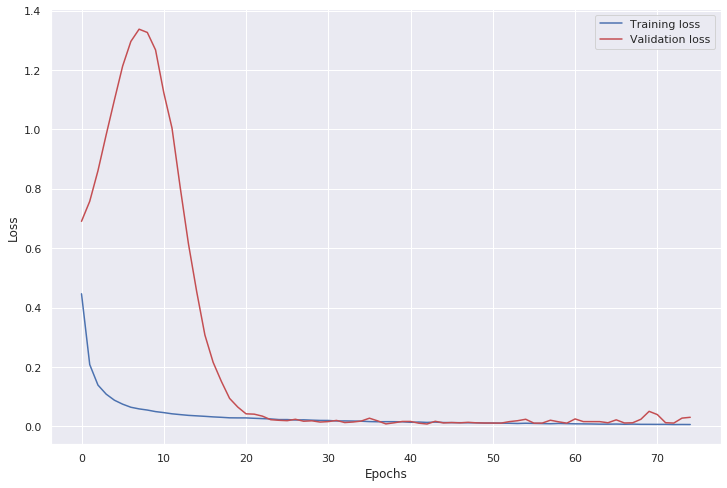

In [13]:
# visualize loss for the training
plt.figure(figsize = (12,8))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss,'b', label='Training loss')
plt.plot(hist_val_loss,'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

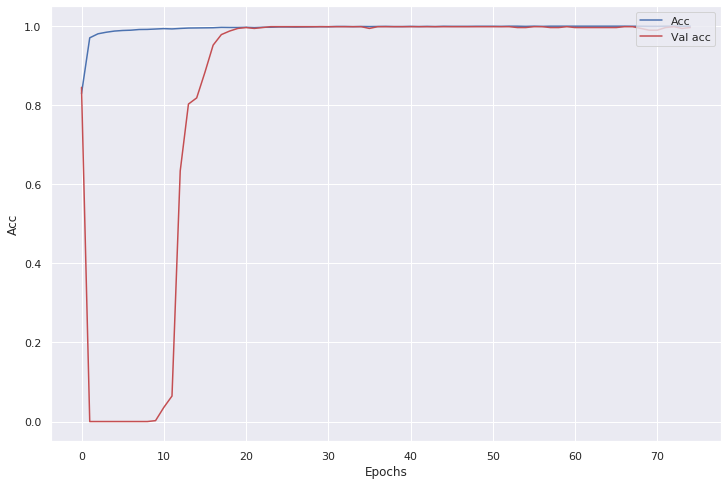

In [14]:
# visualize loss for the training
plt.figure(figsize = (12,8))
hist_loss = history.history['accuracy']
hist_val_loss = history.history['val_accuracy']

plt.plot(hist_loss,'b', label='Acc')
plt.plot(hist_val_loss,'r', label='Val acc')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Acc')

plt.show()

In [26]:
# evaluate accuracy on test set

# need to use the same scaling values of training
X_train = np.array(data)

# drop first column (label)
X_train = X_train[:, 1:]

min = X_train.min()
max = X_train.max()
# these values must be used to scale X_test


FILE_TEST = "ECG5000_TEST_NEW.txt"

data_test = pd.read_csv(FILE_TEST, delim_whitespace = True, header=None, engine = 'python', names=columns)

# convert labels to integer
data_test['label'] = data_test['label'].astype('int32')

# move to binary label
data_test.loc[data_test['label'] == 1, 'label'] = 0

data_test.loc[data_test['label'] > 0, 'label'] = 1

X_test = np.array(data_test)

# drop first column (label)
X_test = X_test[:, 1:]

X_test_scaled = (X_test - min)/(max - min)

# need to trasnform to sort of image (2 dim tensor) for compatibility with input of CNN
X_test_scaled = np.expand_dims(X_test_scaled, axis = 1)

# evaluate the prediction
y_test_pred = model.predict(X_test_scaled)

# which class (0,1) ?
THRESHOLD = 0.5

y_test_pred = (y_test_pred > THRESHOLD)

y_true = np.array(data_test['label'])

# better to reshape
y_test_pred = y_test_pred.reshape(500)
y_true = y_true.reshape(500)

In [33]:
# there is such a simpler way to evaluate a Model in Keras. 
loss, accuracy = model.evaluate(X_test_scaled, y_true)

print('Accuracy on test set is: ', round(accuracy, 3))

16/16 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.9920
Accuracy on test set is:  0.992


In [28]:
from sklearn.metrics import confusion_matrix

In [29]:
conf = confusion_matrix(y_true, y_test_pred)

conf

array([[290,   2],
       [  2, 206]])

In [30]:
TN, FP, FN, TP = conf.ravel()

# sensitivity in used in healthcare. It is also called Recall
sensitivity = float(TP)/(TP + FN)
specificity = float(TN)/(FP + TN)

# it is P(+|disease), the conditioned probability that an anomalous (disease) sample is correctly identified 
print('Sensitivity is: ', round(sensitivity, 3))
# it is P(-|normal) the conditioned probability that an anomalous normal sample is correctly identified 
print('Specificity is: ', round(specificity, 3))

Sensitivity is:  0.99
Specificity is:  0.993


In [31]:
# really good results !!! better than with AutoEncoders